## Imports

In [2]:
import os
import time
import random
import warnings
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from tqdm import notebook
from easydict import EasyDict as edict
from IPython.display import Video

import src.helper_fns as hf

import gym
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
warnings.filterwarnings("ignore", category=DeprecationWarning)

os.environ['SDL_VIDEODRIVER'] = 'dummy'
os.environ['WANDB_NOTEBOOK_NAME'] = 'ppo.ipynb'

plt.rcParams['figure.dpi'] = 100
device = torch.device("cuda")

%load_ext autoreload
%autoreload 2

## Initializations


In [4]:
exp = edict()

exp.exp_name = 'PPO'  # algorithm name, in this case it should be 'PPO'
exp.env_id = 'LunarLander-v2'  # name of the gym environment to be used in this experiment. Eg: Acrobot-v1, CartPole-v1, MountainCar-v0
exp.device = device.type  # save the device type used to load tensors and perform tensor operations

exp.random_seed = True  # set random seed for reproducibility of python, numpy and torch
exp.seed = 1

# name of the project in Weights & Biases (wandb) to which logs are patched. (only if wandb logging is enabled)
# if the project does not exist in wandb, it will be created automatically
wandb_prj_name = f"RLLBC_{exp.env_id}"

# name prefix of output files generated by the notebook
exp.run_name = f"{exp.env_id}__{exp.exp_name}__{exp.seed}__{datetime.now().strftime('%y%m%d_%H%M%S')}"

if exp.random_seed:
    random.seed(exp.seed)
    np.random.seed(exp.seed)
    torch.manual_seed(exp.seed)
    torch.backends.cudnn.deterministic = exp.random_seed

## Rollout Buffer
Creating a rollout buffer based on the number of parallel envs `exp.num_envs` and the number of steps per env `hypp.num_steps`. It is later used to save episode trajectories during agent training. The buffer gets replaced with new trajectories at the beginning of every iteration of the training loop.

In [5]:
hypp = edict()

exp.num_envs = 8  # number of parallel game environments
hypp.num_steps = 128  # number of steps to run in each environment per policy rollout

# Intialize vectorized gym env
envs = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed + i) for i in range(exp.num_envs)])

# RollOut Buffer Init
observations = torch.zeros((hypp.num_steps, exp.num_envs) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((hypp.num_steps, exp.num_envs) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((hypp.num_steps, exp.num_envs)).to(device)
rewards = torch.zeros((hypp.num_steps, exp.num_envs)).to(device)
dones = torch.zeros((hypp.num_steps, exp.num_envs)).to(device)
values = torch.zeros((hypp.num_steps, exp.num_envs)).to(device)

envs.close()

## Agent Model Class

The `Agent` class consists of a deep MLP value function called the `critic`, and a deep MLP policy called the `actor`, both learned during training. 

The class has three methods:
1. `get_value` evaluates the `critic` with a given observation (state) to obtain the learned estimate of the observation's value.
2. `get_action` returns an action. The method first evaluates the `actor` to obtain the un-normalized probabilities of the actions, which is then used to create a categorical distribution over the actions. If `greedy = True` it returns the action with the highest probability else an action sampled from the distribution.
3. `get_action_and_value`, when given an observation, returns the action sampled from the probability distribution (if `action=None`), the respective action's log probability, the entropy of the probability distribution, and the estimate of the observation's value according to the `critic` network

In [6]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        self.actor = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, envs.single_action_space.n), std=0.01),
        )

    def get_value(self, x):
        return self.critic(x)

    def get_action(self, x, greedy=False):
        logits = self.actor(x)
        distribution = Categorical(logits=logits)
        action = distribution.sample() if not greedy else distribution.mode
        return action

    def get_action_and_value(self, x, action=None):
        logits = self.actor(x)
        distr = Categorical(logits=logits)
        if action is None:
            action = distr.sample()
        return action, distr.log_prob(action), distr.entropy(), self.critic(x)

## Training Parameters & Agent Hyperparameters


In [7]:
# flags for logging purposes
exp.enable_wandb_logging = False
exp.capture_video = False  # disable to speed up training

# flags to generate agent's average performance during training
exp.eval_agent = True  # disable to speed up training
exp.eval_count = 10
exp.eval_frequency = 100
exp.device = device.type

# putting the run into the designated log folder for structuring
exp.exp_type = None  # directory the run is saved to. Should be None or a string value

# agent training specific parameters and hyperparameters
hypp.total_timesteps = 600000  # the training duration in number of time steps
hypp.num_minibatches = 32  # number of minibatches for gradient updates
hypp.update_epochs = 3  # epochs of updates after collecting one trajectory

hypp.batch_size = int(exp.num_envs * hypp.num_steps)  # len of the rollout buffer
hypp.minibatch_size = int(hypp.batch_size // hypp.num_minibatches)  # rollout buffer size / minibatch count

hypp.learning_rate = 3e-4  # size of gradient update step
hypp.anneal_lr = True  # when True reduces the learning rate as the training progresses
hypp.gamma = 0.99  # discount factor over future rewards
hypp.norm_adv = True  # whether to normalize the advantages to zero mean unit variance
hypp.clip_coef = 0.2  # the clip coeff of the surrogate PPO-clip objective
hypp.clip_vloss = True  # whether to clip the value loss
hypp.ent_coef = 0.05  # weight of the entropy term in the final loss function.
hypp.vf_coef = 0.5  # weight of the value term in the final loss function
hypp.max_grad_norm = 0.5  # the max norm of the gradients computed

## PPO helper functions

In the following cells there are a few functions that are used during the PPO algorithm:
1. `compute_advantage_estimates` computes the advantage estimates for the explored trajectories.
2. `compute_gae` computes the generalized advantage estimates for the explored trajectories.
3. `normalize_advantages` normalizes the given tensor to zero mean and unit variance.
4. `compute_policy_objective` computes the policy objective that is maximized to improve the agent.
5. `compute_clipped_value_loss` computes an alternative formulation for the value function loss.

In [8]:
def compute_advantage_estimates(rewards, values, dones, next_value, next_done):
    '''
    Computes the estimated advantages from given rewards and estimated values
    :param rewards: accumulated rewards during the rollout (shape [num_steps, num_envs])
    :param values: estimated values of traversed states (shape [nums_steps, num_envs])
    :param next_value: bootstrapped value of the next state after rollout (shape [1, num_envs])
    :param next_done: whether environment is finished in next state after rollout (shape [1, num_envs])
    :return: the estimated advantages of policy (shape [num_steps, num_envs])
    '''
    with torch.no_grad():
        returns = torch.zeros_like(rewards)
        for t in reversed(range(hypp.num_steps)):
            if t == hypp.num_steps - 1:
                nextnonterminal = 1.0 - next_done
                returns[t] = rewards[t] + hypp.gamma * next_value * nextnonterminal
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                returns[t] = rewards[t] + hypp.gamma * returns[t+1] * nextnonterminal
        advantages = returns - values

    return advantages

In [9]:
def compute_gae(rewards, values, dones, next_value, next_done, gae_lambda):
    '''
    Computes the generalized advantage estimates(GAE) for every timestep from given rewards and estimated values
    :param rewards: accumulated rewards during the rollout (shape [num_steps, num_envs])
    :param values: estimated values of traversed states (shape [num_steps, num_envs])
    :param next_value: bootstrapped value of the next state after rollout (shape [1, num_envs])
    :param next_done: whether environment is finished in next state after rollout (shape [1, num_envs])
    :param gae_lambda: scalar coefficient for gae computation
    :return: generalized advantage estimates of trajectory (shape [num_steps, num_envs])
    '''
    # TODO: Part b)
    with torch.no_grad():
        delta = torch.zeros_like(rewards)
        gae = torch.zeros_like(rewards)
        for t in reversed(range(hypp.num_steps)):
            if t == hypp.num_steps - 1:
                nextnonterminal = 1.0 - next_done
                delta[t] = rewards[t] + hypp.gamma * next_value * nextnonterminal - values[t]
                gae[t] = delta[t]
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                delta[t] = rewards[t] + hypp.gamma * values[t+1] * nextnonterminal - values[t]
                gae[t] = delta[t] + gae_lambda * hypp.gamma * gae[t+1] * nextnonterminal
    return gae

In [10]:
# small unittest for verification of implementation
# simulates 2 environments run for 5 steps

rewards_test = torch.tensor([[1., 1., 1., 1., 1.], [1., 1., 1., 1, 1.]]).transpose(0, 1)
dones_test = torch.tensor([[0., 0., 1., 0., 0.], [0., 0., 1., 0., 0.]]).transpose(0, 1)
values_test = torch.tensor([[3., 2., 10., 8., 6.], [0., 1., 2., 1., 1.]]).transpose(0, 1)
next_value_test = torch.tensor([[5., 10.]])
next_done_test = torch.tensor([[0., 1.]])
gae_lamba_test = 0.9

# changing relevant hypp values for the test, saving old values
gamma = hypp.gamma
num_steps = hypp.num_steps
hypp.gamma = 0.95
hypp.num_steps = 5

try:
    test_adv = compute_gae(rewards_test, values_test, dones_test, next_value_test, next_done_test, gae_lamba_test)
    exp_adv = torch.tensor([[-0.955, -1, -2.69425625, -1.51375, -0.25], [1.95, 0., 0.76225, 0.95, 0]]).transpose(0,1)
    assert torch.allclose(test_adv, exp_adv), f"Computed advantages incorrect.\nExpected:\n {exp_adv} \nReceived:\n {test_adv}"
    print("Test ok")
except Exception as e:
    print(e)

# resetting old values again
hypp.gamma = gamma
hypp.num_steps = num_steps

Test ok


In [11]:
def normalize_advantages(advantages):
    '''
    Takes tensor of advantages and normalizes them to zero mean and unit variance
    :param advantages: tensor of advantages to normalize (shape [n])
    :return: tensor of normalized advantages (shape [n])
    '''
    # TODO: Part b)
    # ...
    mean = advantages.mean()
    std = advantages.std()
    return (advantages - mean) / (std + 1e-8)

In [12]:
def compute_policy_objective(advantages, logprob_old, logprob):
    '''
    Computes the policy objective that is being optimized in the gradient step.
    :param advantages: tensor of advantages (shape [n])
    :param logprob_old: tensor of log-probabilites of actions of sampled policy (shape [n])
    :param logprob: tensor of log-probabilites of actions of new policy (shape [n])
    :return: objective function for policy (shape [1])
    '''
    # computing the probability ratio
    logratio = logprob - logprob_old
    ratio = logratio.exp()

    # clipping
    pg_loss1 = advantages * ratio
    pg_loss2 = advantages * torch.clamp(ratio, 1 - hypp.clip_coef, 1 + hypp.clip_coef)
    return torch.min(pg_loss1, pg_loss2).mean()

In [13]:
def compute_clipped_value_loss(returns, old_values, values):
    '''
    Applies the same idea of trust region optimization to the value function,
    constructing a clipped value loss.
    :param returns: batch of returns collected in the trajectory (shape [n])
    :param old_values: batch of value approximations of old policy (shape [n])
    :param values: batch of value approximations of updated policy (shape [n])
    :return the clipped value loss (shape [1])
    '''
    # TODO: Part b)
    # ...
    values_clipped = torch.clamp(values, old_values - hypp.clip_coef, old_values + hypp.clip_coef)
    loss_unclipped = (values - returns) ** 2
    loss_clipped = (values_clipped - returns) ** 2

    return 0.5 * torch.max(loss_unclipped, loss_clipped).mean()

## Training the Agent

In [16]:
# reinit run_name
exp.run_name = f"{exp.env_id}__{exp.exp_name}__{exp.seed}__{datetime.now().strftime('%y%m%d_%H%M%S')}"

# Init tensorboard logging and wandb logging
writer = hf.setup_logging(wandb_prj_name, exp, hypp)

# create two vectorized envs: one to fill the rollout buffer with trajectories, and
# another to evaluate the agent performance at different stages of training
# Note: vectorized environments reset automatically once the episode is finished
envs.close()
envs = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed + i) for i in range(exp.num_envs)])
envs_eval = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed + i) for i in range(exp.eval_count)])

# init list to track agent's performance throughout training
tracked_returns_over_training = []
tracked_episode_len_over_training = []
tracked_episode_count = []
last_evaluated_episode = None  # stores the episode_step of when the agent's performance was last evaluated
greedy_evaluation = True  # whether to perform the evaluation in a greedy way or not
eval_max_return = -float('inf')

# Init observation to start learning
start_time = time.time()
obs = torch.Tensor(envs.reset()).to(device)
done = torch.zeros(exp.num_envs).to(device)
num_updates = int(hypp.total_timesteps // hypp.batch_size)

pbar = notebook.tqdm(range(1, num_updates + 1))

# ------------------------- END RUN INIT --------------------------- #

global_step = 0
episode_step = 0
gradient_step = 0

# Create Agent class Instance and network optimizer
agent = Agent(envs).to(device)
optimizer = optim.Adam(agent.parameters(), lr=hypp.learning_rate, eps=1e-5)

# training loop
for update in pbar:
    # annealing the rate if true
    if hypp.anneal_lr:
        frac = 1.0 - (update - 1.0) / num_updates
        lrnow = frac * hypp.learning_rate
        optimizer.param_groups[0]["lr"] = lrnow

    agent.eval()

    # collect trajectories
    for step in range(0, hypp.num_steps):
        observations[step] = obs
        dones[step] = done

        # sample action and collect value from learned agent policy and value networks
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(obs)
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob

        # execute the game and log data
        next_obs, reward, done, infos = envs.step(action.cpu().numpy())

        for idx, info in enumerate(infos):
            # bootstrap value of the observation when done is true and the episode is truncated
            if (
                done[idx]
                and info.get("terminal_observation") is not None
                and info.get("TimeLimit.truncated", False)
               ):
                terminal_obs = torch.tensor(info["terminal_observation"]).to(device)
                with torch.no_grad():
                    terminal_value = agent.get_value(terminal_obs)
                reward[idx] += hypp.gamma * terminal_value

            # log episode return and length to tensorboard
            if "episode" in info.keys():
                episode_step += 1
                pbar.set_description(f"global_step={global_step}, episodic_return={info['episode']['r']:.3f}")
                writer.add_scalar("rollout/episodic_return", info["episode"]["r"], global_step+idx)
                writer.add_scalar("rollout/episodic_length", info["episode"]["l"], global_step+idx)
                writer.add_scalar("Charts/episode_step", episode_step, global_step)
                writer.add_scalar("Charts/gradient_step", gradient_step, global_step)

        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)

        global_step += 1 * exp.num_envs
        obs = next_obs

# EVALUATION

        # generate average performance statistics of current learned agent
        if exp.eval_agent and episode_step % exp.eval_frequency == 0 and last_evaluated_episode != episode_step:
            last_evaluated_episode = episode_step
            tracked_return, tracked_episode_len = hf.evaluate_agent(envs_eval, agent, exp.eval_count, exp.seed, greedy_actor=greedy_evaluation)
            tracked_returns_over_training.append(tracked_return)
            tracked_episode_len_over_training.append(tracked_episode_len)
            tracked_episode_count.append([episode_step, global_step])

            # if there has been improvment of the model -
            if np.mean(tracked_return) > eval_max_return:
                eval_max_return = np.mean(tracked_return)
                # call helper function save_and_log_agent to save model, create video, log video to wandb
                hf.save_and_log_agent(exp, agent, episode_step, greedy=greedy_evaluation, print_path=False)

#END EVALUATION

    next_done = done.reshape(1, -1)
    agent.train()

    # calculate advantages and returns
    with torch.no_grad():
        # bootstrap at end of rollout
        next_value = agent.get_value(next_obs).reshape(1, -1)
    #advantages = compute_advantage_estimates(rewards, values, dones, next_value, next_done)
    #Part b)
    advantages = compute_gae(rewards, values, dones, next_value, next_done, 0.95)
    returns = advantages + values
    advantages.to(device)
    returns.to(device)

    # flatten the batch
    b_observations = observations.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # optimize the policy and value network
    b_inds = np.arange(hypp.batch_size)
    for epoch in range(hypp.update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, hypp.batch_size, hypp.minibatch_size):
            end = start + hypp.minibatch_size
            mb_inds = b_inds[start:end]

            mb_advantages = b_advantages[mb_inds]
            if hypp.norm_adv:
                mb_advantages = normalize_advantages(mb_advantages)

            _, newlogprob, newentropy, newvalue = agent.get_action_and_value(b_observations[mb_inds], b_actions.long()[mb_inds])

            # computation of policy objective
            pg_loss = compute_policy_objective(mb_advantages, b_logprobs[mb_inds], newlogprob)

            # Value loss
            newvalue = newvalue.view(-1)
            if hypp.clip_vloss:
                v_loss = compute_clipped_value_loss(b_returns[mb_inds], b_values[mb_inds], newvalue)
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            # entropy of probability distribution over actions
            entropy = newentropy.mean()

            # final loss objective for gradient computation
            loss = - pg_loss + hypp.vf_coef * v_loss - hypp.ent_coef * entropy

            optimizer.zero_grad()
            loss.backward()

            # clip gradients
            nn.utils.clip_grad_norm_(agent.parameters(), hypp.max_grad_norm)

            optimizer.step()

            gradient_step += 1

    # Calculating explained variance metric
    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    # log losses to tensorboard summary writer
    writer.add_scalar("hyperparameters/learning_rate", optimizer.param_groups[0]["lr"], global_step)
    writer.add_scalar("train/value_loss", v_loss.item(), global_step)
    writer.add_scalar("train/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("train/entropy", entropy.item(), global_step)
    writer.add_scalar("train/explained_variance", explained_var, global_step)
    writer.add_scalar("Charts/episode_step", episode_step, global_step)
    writer.add_scalar("Charts/gradient_step", gradient_step, global_step)
    writer.add_scalar("others/EPS", int(global_step / (time.time() - start_time)), global_step)

#EVALUATION

# one last evaluation stage
if exp.eval_agent:
    last_evaluated_episode = episode_step
    tracked_return, tracked_episode_len = hf.evaluate_agent(envs_eval, agent, exp.eval_count, exp.seed, greedy_actor=greedy_evaluation)
    tracked_returns_over_training.append(tracked_return)
    tracked_episode_len_over_training.append(tracked_episode_len)
    tracked_episode_count.append([episode_step, global_step])

    # if there has been improvement of the model -
    if np.mean(tracked_return) > eval_max_return:
        eval_max_return = np.mean(tracked_return)
        # call helper function save_and_log_agent to save model, create video, log video to wandb
        hf.save_and_log_agent(exp, agent, episode_step, greedy=greedy_evaluation, print_path = True)

    hf.save_tracked_values(tracked_returns_over_training, tracked_episode_len_over_training, tracked_episode_count, exp.eval_count, exp.run_name, exp.exp_type)

# END EVALUATION 

# CLEANING/SAVING
envs.close()
envs_eval.close()
writer.close()
if wandb.run is not None:
    wandb.finish(quiet=True)
    wandb.init(mode="disabled")

hf.save_train_config_to_yaml(exp, hypp)

  0%|          | 0/585 [00:00<?, ?it/s]

## Agent Evaluation


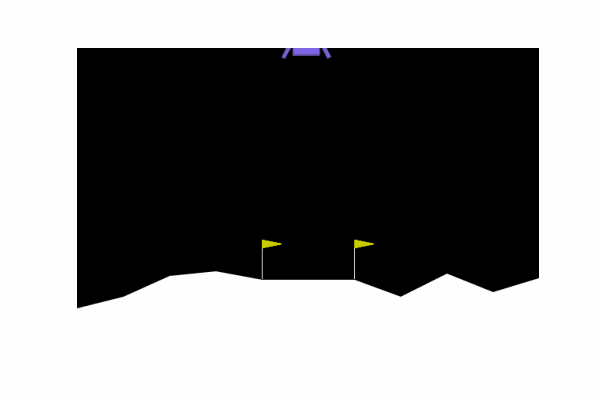

In [19]:
agent_name = exp.run_name
agent_exp_type = exp.exp_type  # both are needed to identify the agent location


exp_folder = "" if agent_exp_type is None else agent_exp_type
filepath, _ = hf.create_folder_relative(f"{exp_folder}/{agent_name}/videos")

hf.record_video(exp.env_id, agent_name, f"{filepath}/best.gif", exp_type=agent_exp_type, greedy=True)
Video(data=f"{filepath}/best.gif", html_attributes='loop autoplay', embed=True)

## Performance of Agents during Training

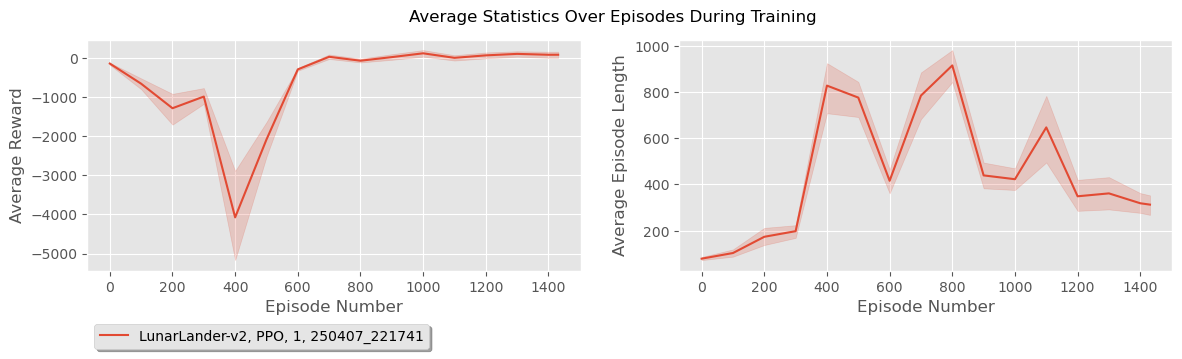

In [18]:
eval_params = edict()  # eval_params - evaluation settings for trained agent

eval_params.run_name00 = exp.run_name
eval_params.exp_type00 = exp.exp_type

# eval_params.run_name01 = "CartPole-v1__PPO__1__230302_224624"
# eval_params.exp_type01 = None

# eval_params.run_name02 = "CartPole-v1__PPO__1__230302_221245"
# eval_params.exp_type02 = None

agent_labels = []

episode_axis_limit = None

hf.plotter_agents_training_stats(eval_params, agent_labels, episode_axis_limit, plot_returns=True, plot_episode_len=True)